In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

## Algorithm 1 (features + labels private)

<img src="../image/alg1_2019.png" width="400" height="200">

In [2]:
def sample_dataset(n, p, c, k):
    x = np.random.choice([-1, 1], (n, p))
    noise = np.random.uniform(-c, c, n)
    
    theta_star = np.random.uniform(-1, 1, p)

    # make theta_star k-sparse randomly
    index = np.random.choice(range(p), k)
    for i in index:
        theta_star[i] = 0
        
    y = x @ theta_star + noise
    return x, y, theta_star

In [23]:
def experiment_setup(n, p):
    T = int(np.ceil(np.log2(n / p))) # number of iterations, rounded-up
    bucket_size = int(np.floor(n / T))
    theta_prev = np.zeros(p) # theta_zero

    index_set = [] # splitting into buckets
    for t in range(T):
        start = t * bucket_size
        end = (t + 1) * bucket_size - 1
        if t == T - 1:
            end = n - 1
            
        index_set.append((start, end))

    return T, theta_prev, index_set

In [19]:
T, theta_prev, index_set = experiment_setup(500000, 16)

In [20]:
theta_prev

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [21]:
T

15

In [22]:
index_set

[(0, 33332),
 (33333, 66665),
 (66666, 99998),
 (99999, 133331),
 (133332, 166664),
 (166665, 199997),
 (199998, 233330),
 (233331, 266663),
 (266664, 299996),
 (299997, 333329),
 (333330, 366662),
 (366663, 399995),
 (399996, 433328),
 (433329, 466661),
 (466662, 499999)]

In [12]:
def randomizer(x):
    return x

# TODO - implement randomizer

In [13]:
# params: v - vector, k - sparsity
# returns an updates vector v which is k-sparse

def truncation(v, k):
    p = len(v)
    argmin_k_indices = np.argpartition(v, -(p - k))[:(p - k)]
    
    for j in argmin_k_indices:
            v[j] = 0

    return v

In [14]:
truncation([100, 2, 3, 4, 5, 6, 7], 3)

[100, 0, 0, 0, 0, 6, 7]

In [15]:
def run_experiment(n, p, k=3, eta=0.1, c=0.05, verbose=False):
    x, y, theta_star = sample_dataset(n, p, c, k)
    T, theta_prev, index_set = experiment_setup(n, p)
    
    for t in range(T):
        if verbose:
            print(f'\n============================== iteration {t} ==================================')
        
        all_gradients = []

        # Line 3: users computes their gradient locally and adds noise (randomizer)
        for i in range(index_set[t][0], index_set[t][1]):
            nabla_i = x[i].T * (theta_prev @ x[i] - y[i])
            nabla_i = randomizer(nabla_i) # currently, identity function
            all_gradients.append(nabla_i)

        if verbose:
            print("\nAll gradients input")
            print(np.array(all_gradients).shape)
    
        # Line 4: aggregate gradients
        nabla_prev = np.array(all_gradients).sum(axis=0) / len(all_gradients)
        if verbose:
            print("\nLine 4. Aggregated gradient")
            print(np.array(nabla_prev).shape)
    
        # Line 5: perform gradient descend
        theta_t = theta_prev - eta * nabla_prev
        if verbose:
            print("\nLine 5. Gradient descent")
            print(theta_t)
    
        # Line 6: truncation - make k-sparse
        theta_t = truncation(theta_t, k)
        if verbose:
            print("\nLine 6. Make sparse")   
            print(theta_t)

        # Line 7: l2 ball projection
        norm_theta_t = LA.norm(theta_t, ord=2)
        if norm_theta_t > 1:
            theta_t = theta_t / LA.norm(theta_t, ord=2)
        if verbose:
            print("\nLine 7. L2 projection to ball")   
            print(theta_t)

        # update for next iteration
        theta_prev = theta_t


    # compute error
    e = LA.norm(theta_t - theta_star, ord=2) / LA.norm(theta_star, ord=2)
    return e

In [16]:
# DEBUG
# run_experiment(100, 10, k=5, eta=0.2)

## Experiment 1 - varying dimensionality (p) - figure 1a

In [17]:
n_values = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
p_values = [16, 64, 128, 256]
k = 10
results = {}

In [18]:
for n in n_values:
    for p in p_values:
        min_error = 1.0
        for i in range(10):
            e = run_experiment(int(n * (10 ** 5)), p, k, eta=0.1, c=0.05, verbose=False)
            if e < min_error:
                min_error = e
            
        if not p in results:
            results[p] = []
        results[p].append(min_error)
        print(n, p, min_error)

1 16 0.30017097283956395
1 64 0.8992444986370464
1 128 0.957547701346828
1 256 0.975796180685551
1.5 16 0.6001832679025787
1.5 64 0.8951095708056325
1.5 128 0.9578251141817127
1.5 256 0.978088583423047
2 16 0.5351770226801503
2 64 0.890374056201002
2 128 0.9534919769755145
2 256 0.9750282540082593
2.5 16 0.4917846079606275
2.5 64 0.8939682043252397
2.5 128 0.9306193694324462
2.5 256 0.973235885861596
3 16 0.23777777668305636
3 64 0.910502964463574
3 128 0.9430777692076784
3 256 0.9746335658611414
3.5 16 0.47272880126978073
3.5 64 0.8703914869108099
3.5 128 0.9446307777216213
3.5 256 0.9722671431664076
4 16 0.484772564685909
4 64 0.8689529901100262
4 128 0.964201115658065
4 256 0.9788443235947599
4.5 16 0.5115363471021566
4.5 64 0.8916090073996737
4.5 128 0.949916139060851
4.5 256 0.9776598603559732
5 16 0.4709339987748052
5 64 0.9055116478216376
5 128 0.935407681046756
5 256 0.9700735598719943


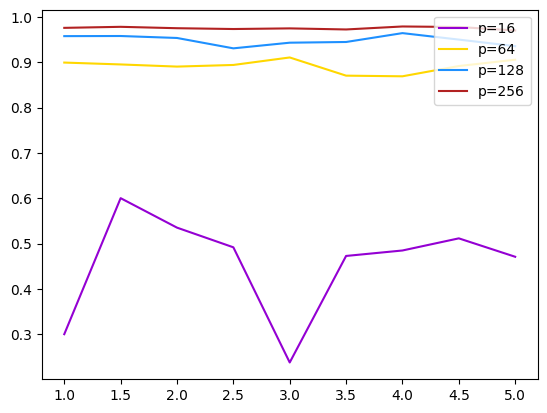

In [24]:
colors = ["darkviolet", "gold", "dodgerblue", "firebrick"]
for i in range(len(p_values)):
    p = p_values[i]
    plt.plot(n_values, results[p], label=f'p={p}', color=colors[i])

plt.legend(loc=1)
plt.show()

## Experiment 2 - varying sparsity level (k) - figure 1b

In [12]:
n_values = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
k_values = [10, 20, 40, 100]
p = 64
results = {}

In [13]:
for n in n_values:
    for k in k_values:
        min_error = 1.0
        for i in range(10):
            e = run_experiment(int(n * (10 ** 5)), p, k, eta=0.1, c=0.05, verbose=False)
            if e < min_error:
                min_error = e
            
        if not k in results:
            results[k] = []
        results[k].append(min_error)
        print(n, k, min_error)

1 10 0.9041423312121006
1 20 0.8102035079616242
1 40 0.7495957723386745
1 100 0.492809439865959
1.5 10 0.9034891897938213
1.5 20 0.8271356184487463
1.5 40 0.7800402336306147
1.5 100 0.6986156776177936
2 10 0.9049426922706604
2 20 0.8593549228138108
2 40 0.7655603416396741
2 100 0.7430632377756549
2.5 10 0.8822003333123669
2.5 20 0.816872877833206
2.5 40 0.7879378369911242
2.5 100 0.6474729571403989
3 10 0.8969654952384152
3 20 0.8719883757056505
3 40 0.7510587162370568
3 100 0.5092696733033895
3.5 10 0.8968608348989012
3.5 20 0.9106164435480829
3.5 40 0.7397010827186222
3.5 100 0.5383232544022649
4 10 0.8524211047478105
4 20 0.8729328515365034
4 40 0.7546425670036855
4 100 0.5766451902610202
4.5 10 0.9030052015667105
4.5 20 0.8692755700446286
4.5 40 0.7520926746495112
4.5 100 0.6389971110519704


KeyboardInterrupt: 

In [ ]:
colors = ["darkviolet", "gold", "dodgerblue", "firebrick"]
for i in range(len(k_values)):
    k = k_values[i]
    plt.plot(n_values, results[k], label=f's={k}', color=colors[i])

plt.legend(loc=1)
plt.show()